In [ ]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
import gym
env = gym.make("LunarLander-v2")

     |████████████████████████████████| 450kB 27.2MB/s 


In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, 
            n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions

class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
            max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=256, fc2_dims=256)
        self.Q_next = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=64, fc2_dims=64)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next,dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                       else self.eps_min


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import gym

def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="Green")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="red")
    ax.tick_params(axis='y', colors="red")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="Blue")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

class SkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(SkipEnv, self).__init__(env)
        self._skip = skip

    def step(self, action):
        t_reward = 0.0
        done = False
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            t_reward += reward
            if done:
                break
        return obs, t_reward, done, info

    def reset(self):
        self._obs_buffer = []
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

class PreProcessFrame(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(PreProcessFrame, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255,
                                                shape=(80,80,1), dtype=np.uint8)
    def observation(self, obs):
        return PreProcessFrame.process(obs)

    @staticmethod
    def process(frame):

        new_frame = np.reshape(frame, frame.shape).astype(np.float32)

        new_frame = 0.299*new_frame[:,:,0] + 0.587*new_frame[:,:,1] + \
                    0.114*new_frame[:,:,2]

        new_frame = new_frame[35:195:2, ::2].reshape(80,80,1)

        return new_frame.astype(np.uint8)

class MoveImgChannel(gym.ObservationWrapper):
    def __init__(self, env):
        super(MoveImgChannel, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,
                            shape=(self.observation_space.shape[-1],
                                   self.observation_space.shape[0],
                                   self.observation_space.shape[1]),
                            dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class ScaleFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        self.observation_space = gym.spaces.Box(
                             env.observation_space.low.repeat(n_steps, axis=0),
                             env.observation_space.high.repeat(n_steps, axis=0),
                             dtype=np.float32)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=np.float32)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

def make_env(env_name):
    env = gym.make(env_name)
    env = SkipEnv(env)
    env = PreProcessFrame(env)
    env = MoveImgChannel(env)
    env = BufferWrapper(env, 4)
    return ScaleFrame(env)

episode  0 score -362.80 average score -362.80 epsilon 0.98
episode  1 score -68.97 average score -215.89 epsilon 0.94
episode  2 score -329.75 average score -253.84 epsilon 0.88
episode  3 score -230.69 average score -248.06 epsilon 0.83
episode  4 score -139.40 average score -226.32 epsilon 0.78
episode  5 score -158.28 average score -214.98 epsilon 0.70
episode  6 score -74.98 average score -194.98 epsilon 0.57
episode  7 score -205.44 average score -196.29 epsilon 0.48
episode  8 score -227.37 average score -199.74 epsilon 0.28
episode  9 score -153.77 average score -195.15 epsilon 0.17
episode  10 score -303.21 average score -204.97 epsilon 0.01
episode  11 score -120.84 average score -197.96 epsilon 0.01
episode  12 score -101.70 average score -190.55 epsilon 0.01
episode  13 score -196.95 average score -191.01 epsilon 0.01
episode  14 score -77.30 average score -183.43 epsilon 0.01
episode  15 score -118.90 average score -179.40 epsilon 0.01
episode  16 score -68.69 average scor

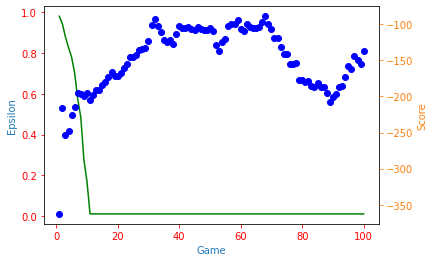

In [ ]:
import gym
#from simple_dqn_torch_2020 import Agent
#from utils import plotLearning
import numpy as np

if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=4, eps_end=0.01,
                  input_dims=[8], lr=0.0005)
    scores, eps_history = [], []
    n_games = 100
    
    for i in range(n_games):
        score = 0
        done = False
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, 
                                    observation_, done)
            agent.learn()
            observation = observation_
        scores.append(score)
        eps_history.append(agent.epsilon)

        avg_score = np.mean(scores[-100:])

        print('episode ', i, 'score %.2f' % score,
                'average score %.2f' % avg_score,
                'epsilon %.2f' % agent.epsilon)
    x = [i+1 for i in range(n_games)]
    filename = 'lunar_lander.png'
    plotLearning(x, scores, eps_history, filename)

episode  0 score -95.80 average score -95.80 epsilon 1.00
episode  1 score -161.43 average score -128.62 epsilon 0.95
episode  2 score -453.64 average score -236.96 epsilon 0.89
episode  3 score -97.15 average score -202.01 epsilon 0.84
episode  4 score -324.49 average score -226.50 epsilon 0.79
episode  5 score -200.02 average score -222.09 epsilon 0.71
episode  6 score -90.85 average score -203.34 epsilon 0.63
episode  7 score -49.55 average score -184.12 epsilon 0.59
episode  8 score -246.49 average score -191.05 epsilon 0.55
episode  9 score -156.40 average score -187.58 epsilon 0.49
episode  10 score -125.41 average score -181.93 epsilon 0.35
episode  11 score -132.36 average score -177.80 epsilon 0.01
episode  12 score -366.95 average score -192.35 epsilon 0.01
episode  13 score -32.12 average score -180.90 epsilon 0.01
episode  14 score -523.10 average score -203.72 epsilon 0.01
episode  15 score -411.68 average score -216.72 epsilon 0.01
episode  16 score -184.39 average score 

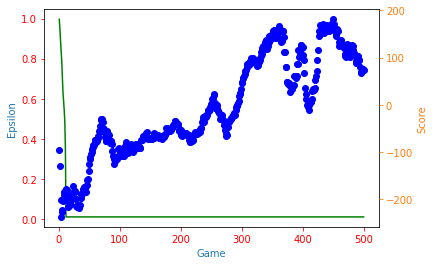

In [ ]:
import gym
#from simple_dqn_torch_2020 import Agent
#from utils import plotLearning
import numpy as np

if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=4, eps_end=0.01,
                  input_dims=[8], lr=0.0005)
    scores, eps_history = [], []
    n_games = 500
    
    for i in range(n_games):
        score = 0
        done = False
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, 
                                    observation_, done)
            agent.learn()
            observation = observation_
        scores.append(score)
        eps_history.append(agent.epsilon)

        avg_score = np.mean(scores[-100:])

        print('episode ', i, 'score %.2f' % score,
                'average score %.2f' % avg_score,
                'epsilon %.2f' % agent.epsilon)
    x = [i+1 for i in range(n_games)]
    filename = 'lunar_lander.png'
    plotLearning(x, scores, eps_history, filename)

episode  0 score -91.13 average score -91.13 epsilon 1.00
episode  1 score -221.12 average score -156.12 epsilon 0.95
episode  2 score -151.77 average score -154.67 epsilon 0.89
episode  3 score -115.40 average score -144.86 epsilon 0.83
episode  4 score -52.36 average score -126.36 epsilon 0.78
episode  5 score -84.89 average score -119.44 epsilon 0.72
episode  6 score -139.38 average score -122.29 epsilon 0.66
episode  7 score -100.20 average score -119.53 epsilon 0.59
episode  8 score -139.61 average score -121.76 epsilon 0.51
episode  9 score -106.86 average score -120.27 epsilon 0.44
episode  10 score -420.26 average score -147.54 epsilon 0.35
episode  11 score 18.98 average score -133.67 epsilon 0.29
episode  12 score -67.94 average score -128.61 epsilon 0.21
episode  13 score -22.10 average score -121.00 epsilon 0.01
episode  14 score -119.90 average score -120.93 epsilon 0.01
episode  15 score -17.46 average score -114.46 epsilon 0.01
episode  16 score -236.21 average score -12

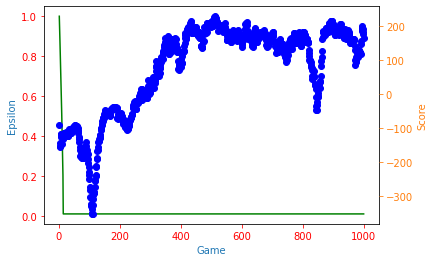

In [ ]:
import gym
#from simple_dqn_torch_2020 import Agent
#from utils import plotLearning
import numpy as np

if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=4, eps_end=0.01,
                  input_dims=[8], lr=0.0005)
    scores, eps_history = [], []
    n_games = 1000
    
    for i in range(n_games):
        score = 0
        done = False
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, 
                                    observation_, done)
            agent.learn()
            observation = observation_
        scores.append(score)
        eps_history.append(agent.epsilon)

        avg_score = np.mean(scores[-100:])

        print('episode ', i, 'score %.2f' % score,
                'average score %.2f' % avg_score,
                'epsilon %.2f' % agent.epsilon)
    x = [i+1 for i in range(n_games)]
    filename = 'lunar_lander.png'
    plotLearning(x, scores, eps_history, filename)

episode  0 score -88.63 average score -88.63 epsilon 0.99
episode  1 score -93.02 average score -90.83 epsilon 0.95
episode  2 score -265.85 average score -149.17 epsilon 0.90
episode  3 score -119.05 average score -141.64 epsilon 0.87
episode  4 score -181.35 average score -149.58 epsilon 0.82
episode  5 score -263.85 average score -168.62 epsilon 0.73
episode  6 score -109.47 average score -160.17 epsilon 0.65
episode  7 score -93.59 average score -151.85 epsilon 0.57
episode  8 score -105.75 average score -146.73 epsilon 0.51
episode  9 score -102.42 average score -142.30 epsilon 0.43
episode  10 score -56.72 average score -134.52 epsilon 0.33
episode  11 score -135.34 average score -134.59 epsilon 0.02
episode  12 score -127.22 average score -134.02 epsilon 0.01
episode  13 score -100.78 average score -131.65 epsilon 0.01
episode  14 score -127.25 average score -131.35 epsilon 0.01
episode  15 score -167.42 average score -133.61 epsilon 0.01
episode  16 score -190.37 average score 

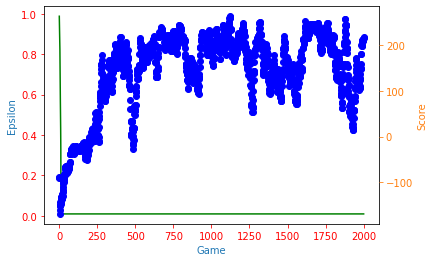

In [ ]:
import gym
#from simple_dqn_torch_2020 import Agent
#from utils import plotLearning
import numpy as np

if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=4, eps_end=0.01,
                  input_dims=[8], lr=0.0005)
    scores, eps_history = [], []
    n_games = 2000
    
    for i in range(n_games):
        score = 0
        done = False
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, 
                                    observation_, done)
            agent.learn()
            observation = observation_
        scores.append(score)
        eps_history.append(agent.epsilon)

        avg_score = np.mean(scores[-100:])

        print('episode ', i, 'score %.2f' % score,
                'average score %.2f' % avg_score,
                'epsilon %.2f' % agent.epsilon)
    x = [i+1 for i in range(n_games)]
    filename = 'lunar_lander.png'
    plotLearning(x, scores, eps_history, filename)